# Model Generation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import pandas as pd

import torch
import pytorch_lightning as pl

from pynas.core.population import Population
from datasets.RawClassifier.loader import RawClassifierDataModule

# Define dataset module
root_dir = '/Data_large/marine/PythonProjects/OtherProjects/lpl-PyNas/data/RawClassifier'
dm = RawClassifierDataModule(root_dir, batch_size=4, num_workers=2, transform=None)

config = configparser.ConfigParser()
config.read('config.ini')
def setting():
    pd.set_option('display.max_colwidth', None)
    # Logging
    logs_directory = str(config['GA']['logs_dir_GA'])
    # Torch stuff
    seed = config.getint(section='Computation', option='seed')
    pl.seed_everything(seed=seed, workers=True)  # For reproducibility
    torch.set_float32_matmul_precision("medium")  # to make lightning happy
    num_workers = config.getint(section='Computation', option='num_workers')
    accelerator = config.get(section='Computation', option='accelerator')
    log_learning_rate=None
    batch_size=None
    # Get model parameters
    log_lr = log_learning_rate if log_learning_rate is not None else config.getfloat(section='Search Space', option='default_log_lr')
    lr = 10**log_lr
    bs = batch_size if batch_size is not None else config.getint(section='Search Space', option='default_bs')
    print(f"-----------The batch size of the data to be loaded in the model is: {bs}-----------")
    print(f"-----------The learning rate of the data to be loaded in the model is: {lr}-----------")
    
setting()

Seed set to 42


-----------The batch size of the data to be loaded in the model is: 4-----------
-----------The learning rate of the data to be loaded in the model is: 0.001-----------


In [3]:
# Model parameters
max_layers = 3
max_iter = int(config['GA']['max_iterations'])
# GA parameters
n_individuals = int(config['GA']['population_size'])
mating_pool_cutoff = float(config['GA']['mating_pool_cutoff'])
mutation_probability = float(config['GA']['mutation_probability'])

pop = Population(n_individuals=20, max_layers=max_layers, dm=dm, max_parameters=400_000)

In [4]:
pop.initial_poll()

Generating Population:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Population: 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


In [5]:
pop.df

,Generation,Layers,Fitness,Metric,FPS,Params
0,0,"[{'layer_type': 'ConvAct', 'out_channels_coefficient': 8, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'ResNetBlock', 'reduction_factor': '2', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 7, 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}]",0.0,None,None,40235
1,0,"[{'layer_type': 'Dropout', 'dropout_rate': 0.31}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvBnAct', 'out_channels_coefficient': 12, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 8, 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}]",0.0,None,None,78747
2,0,"[{'layer_type': 'MBConvNoRes', 'expansion_factor': '6', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 8, 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvAct', 'out_channels_coefficient': 12, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}]",0.0,None,None,60451
3,0,"[{'layer_type': 'ConvAct', 'out_channels_coefficient': 7, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'MBConvNoRes', 'expansion_factor': '6', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'ConvBnAct', 'out_channels_coefficient': 8, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}]",0.0,None,None,36249
4,0,"[{'layer_type': 'ResNetBlock', 'reduction_factor': '4', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvSE', 'out_channels_coefficient': 5, 'kernel_size': '3', 'stride': '1', 'padding': '2', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'Dropout', 'dropout_rate': 0.24}, {'layer_type': 'AvgPool'}]",0.0,None,None,503
5,0,"[{'layer_type': 'ConvSE', 'out_channels_coefficient': 4, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 5, 'activation': 'GELU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvSE', 'out_channels_coefficient': 7, 'kernel_size': '3', 'stride': '1', 'padding': '2', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}]",0.0,None,None,293795
6,0,"[{'layer_type': 'ConvBnAct', 'out_channels_coefficient': 10, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'MBConv', 'expansion_factor': '4', 'activation': 'GELU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvAct', 'out_channels_coefficient': 5, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}]",0.0,None,None,54523
7,0,"[{'layer_type': 'MBConv', 'expansion_factor': '3', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvBnAct', 'out_channels_coefficient': 5, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 8, 'activation': 'GELU'}, {'layer_type': 'MaxPool'}]",0.0,None,None,14211
8,0,"[{'layer_type': 'ConvBnAct', 'out_channels_coefficient': 4, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvSE', 'out_channels_coefficient': 9, 'kernel_size': '3', 'stride': '1', 'padding': '2', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'Dropout', 'dropout_rate': 0.43}, {'layer_type': 'MaxPool'}]",0.0,None,None,10259
9,0,"[{'layer_type': 'ResNetBlock', 'reduction_factor': '4', 'activation': 'GELU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 9, 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                       | Params | Mode 
------------------------------------------------------------------------
0 | model            | Sequential                 | 6.4 M  | train
1 | loss_fn          | CrossEntropyLoss           | 0      | train
2 | accuracy         | MulticlassAccuracy         | 0      | train
3 | f1_score         | MulticlassF1Score          | 0      | train
4 | mcc              | MulticlassMatthewsCorrCoef | 0      | train
5 | conf_matrix      | MulticlassConfusionMatrix  | 0      | train
6 | conf_matrix_pred | MulticlassConfusionMatrix  | 0      | train
------------------------------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.409    Total estimated model params size (MB)
55        Modules in train mo

/home/vessel/anaconda3/envs/pynas/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s, v_num=6, train_loss=0.428, train_accuracy=0.757, train_f1_score=0.744, train_mcc=0.644]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s, v_num=6, train_loss=0.428, train_accuracy=0.757, train_f1_score=0.744, train_mcc=0.644]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 28/28 [00:10<00:00,  2.71it/s]


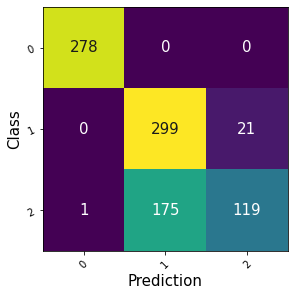

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            fps            │     533.712158203125      │
│       test_accuracy       │    0.7787338495254517     │
│       test_f1_score       │    0.7580157518386841     │
│         test_loss         │    0.4286094009876251     │
│         test_mcc          │    0.6987448930740356     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4286094009876251,
  'test_accuracy': 0.7787338495254517,
  'test_f1_score': 0.7580157518386841,
  'test_mcc': 0.6987448930740356,
  'fps': 533.712158203125}]

In [6]:
pop.train_individual(idx=0, task='classification', lr=0.001, epochs=10, batch_size=32)

In [8]:
pop._update_df()
pop.df.head()

,Generation,Layers,Fitness,Metric,FPS,Params
0,0,"[{'layer_type': 'ConvAct', 'out_channels_coefficient': 8, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'ResNetBlock', 'reduction_factor': '2', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 7, 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}]",0.0,None,None,40235
1,0,"[{'layer_type': 'Dropout', 'dropout_rate': 0.31}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvBnAct', 'out_channels_coefficient': 12, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 8, 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}]",0.0,None,None,78747
2,0,"[{'layer_type': 'MBConvNoRes', 'expansion_factor': '6', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 8, 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvAct', 'out_channels_coefficient': 12, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}]",0.0,None,None,60451
3,0,"[{'layer_type': 'ConvAct', 'out_channels_coefficient': 7, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'MBConvNoRes', 'expansion_factor': '6', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'ConvBnAct', 'out_channels_coefficient': 8, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}]",0.0,None,None,36249
4,0,"[{'layer_type': 'ResNetBlock', 'reduction_factor': '4', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvSE', 'out_channels_coefficient': 5, 'kernel_size': '3', 'stride': '1', 'padding': '2', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'Dropout', 'dropout_rate': 0.24}, {'layer_type': 'AvgPool'}]",0.0,None,None,503


In [10]:
pop[0].results

[{'test_loss': 0.4286094009876251,
  'test_accuracy': 0.7787338495254517,
  'test_f1_score': 0.7580157518386841,
  'test_mcc': 0.6987448930740356,
  'fps': 533.712158203125}]

# Start Chain

Training of the model fresh created.

In [ ]:
from myFit import FitnessEvaluator
from handler.generic_lightning_module import GenericLightningSegmentationNetwork

evaluator = FitnessEvaluator()

class NASTrainer:
    def __init__(self, population, idx, dm, lr, max_epochs=25):
        self.population = population
        self.idx = idx
        self.dm = dm
        self.lr = lr
        self.max_epochs = max_epochs
        
        # Build the model from the selected individual.
        layers = self.population[self.idx].parsed_layers
        self.constructed_model, is_valid = self.population.build_model(layers)
        if not is_valid:
            raise ValueError("Constructed model is not valid.")
        
        self.LM = GenericLightningSegmentationNetwork(
            model=self.constructed_model,
            learning_rate=self.lr,
        )
    
    def train(self):
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            accelerator="gpu" if torch.cuda.is_available() else "cpu"
        )
        # Train the lightning model
        self.trainer.fit(self.LM, self.dm)
        self.results = self.trainer.test(self.LM, self.dm)

    
    
    def save_model(self, save_torchscript=True, 
                   ts_save_path=None,
                   save_standard=True, 
                   std_save_path=None):
        # Use generation attribute from the Population object.
        gen = self.population.generation
        
        if ts_save_path is None:
            ts_save_path = f"models_traced/generation_{gen}/model_and_architecture_{self.idx}.pt"
        if std_save_path is None:
            std_save_path = f"models_traced/generation_{gen}/model_{self.idx}.pth"
        
        # Save the results to a text file.
        with open(f"models_traced/generation_{gen}/results_model_{self.idx}.txt", "w") as f:
            f.write("Test Results:\n")
            for key, value in self.results[0].items():
                f.write(f"{key}: {value}\n")
        
        # Prepare dummy input from dm.input_shape
        input_shape = self.dm.input_shape
        if len(input_shape) == 3:
            input_shape = (1,) + input_shape
        device = next(self.LM.parameters()).device
        example_input = torch.randn(*input_shape).to(device)
        
        self.LM.eval()  # set the model to evaluation mode
        
        if save_torchscript:
            traced_model = torch.jit.trace(self.LM.model, example_input)
            traced_model.save(ts_save_path)
            print(f"Scripted (TorchScript) model saved at {ts_save_path}")
        
        if save_standard:
            # Retrieve architecture code from the individual.
            arch_code = self.population[self.idx].architecture
            save_dict = {"state_dict": self.LM.model.state_dict()}
            if arch_code is not None:
                save_dict["architecture_code"] = arch_code
            torch.save(save_dict, std_save_path)
            print(f"Standard model saved at {std_save_path}")


# To Be Rewritten with Bash Logic:

This part of the code train the whole population one individual at the time and can be performed on single individuals in parallel. Using bash we can run parallel training. 

In [ ]:
from api import api_call


# TODO: Implement the API call to evaluate the model and return the results.

# population loading from saved files
pop.load_dataframe(0)
pop.load_population(0)

# Train the models in the population           
idx = 0 # This must be input argument

nt = NASTrainer(population=pop, idx=idx, dm=dm, lr=1e-3, max_epochs=30)
nt.train()
nt.save_model()


# API to update the population with the results from the model training
result = api_call() # caller_api(nt.model)

# 1) Update the population with the results from the model training
fps = nt.results[0]['fps']
metric = nt.results[0]['test_mcc']
pop[idx].iou = nt.results[0]['test_mcc']
pop[idx].fps = nt.results[0]['fps']

# TODO> Implement the fitness function with more rigurous evaluation parameters (rn the fitness is not the best)
pop[idx].fitness = evaluator.weighted_sum_exponential(fps, metric)

# 2) Update the df. TODO: insert this logic in _update_df method.
pop.df.loc[idx, 'Fitness'] = pop[idx].fitness
pop.df.loc[idx, 'Metric'] = pop[idx].iou
pop.df.loc[idx, 'FPS'] = pop[idx].fps


pop.save_dataframe()
pop.save_population()




In [ ]:
if idx == len(pop) - 1:
    # Evolve the population
    pop.evolve(mating_pool_cutoff=mating_pool_cutoff, mutation_probability=0.85, k_best=1, n_random=3)

# Inference

Using the evaluated and saved model. We use the traced pytroch model (.pt) to load and execute inference.

In [ ]:
# Load the saved TorchScript model and test with a dummy input.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_path = "model_and_architecture.pt"
loaded_model = torch.jit.load(save_path, map_location=device)
loaded_model.eval()

# Ensure input is moved to the correct device
example_input = torch.randn(1, *dm.input_shape).to(device)
example_input = example_input.to(device)

with torch.no_grad():
    output = loaded_model(example_input)
print("Output from the loaded model:", output)